# Object-Oriented Demo

---

Demo for the class-based features of `climpred`.

In [1]:
import numpy as np
import xarray as xr
import climpred as cp
import matplotlib.pyplot as plt
%matplotlib inline
import proplot as plot

# Reference Ensemble

Load in DPLE (initialized ensemble), FOSI (reconstruction that initializes the ensemble), and some SST data.

**NOTE**: This demo is just for the ensemble mean of DPLE.

In [2]:
def _load_dple():
    dple = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                     'CESM-DP-LE.SST.annmean.anom.nc')['anom']
    dple = dple.sel(S=slice(1955, 2015))
    dple = dple.mean('M')
    dple = dple.rename({'S': 'initialization', 'L': 'time', })
    dple.name = 'SST'
    return dple

def _load_fosi():
    fosi = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                       'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.SST.024901-031612.nc')['SST']
    fosi = fosi.sel(time=slice('1955', '2015'))
    fosi = fosi.groupby('time.year').mean('time')
    fosi = fosi.rename({'year': 'initialization'})
    return fosi

def _load_data():
    data = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                           'ERSSTv4.global.mean.nc')['sst']
    data = data.rename({'year': 'initialization'})
    data.name = 'SST'
    return data

dple = _load_dple().to_dataset()
fosi = _load_fosi().to_dataset()
data = _load_data().to_dataset()

There are currently two types of objects (like dataset and dataarray). One is the ReferenceEnsemble, which are ensembles that are initialized off of something like a reconstruction or data. The other is a PerfectModelEnsemble, like MPI's setup.

In [3]:
dp = cp.ReferenceEnsemble(dple)
print(dp)

<climpred.ReferenceEnsemble>
Initialized Ensemble:
    SST      (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
References:
    None


For a `ReferenceEnsemble` type, you can add multiple references. Here, we will add the reconstruction (FOSI) and a dataset (ERSST). Multiple checks go into play here under the hood, ensuring that dimensions are named according to our rules and that references match all initialized dimensions (except for time).

We can also have multiple variables per reference and decadal prediction object.

In [4]:
# dummy/repetitive data to show ability to work with multiple
# variables.
dple['SALT'] = _load_dple()
fosi['SALT'] = ('initialization', np.random.randn(61))
data['SALT'] = ('initialization', np.random.randn(61))

In [5]:
dp = cp.ReferenceEnsemble(dple)

In [6]:
help(dp.add_reference)

Help on method add_reference in module climpred.classes:

add_reference(xobj, name) method of climpred.classes.ReferenceEnsemble instance
    uninitialized things should all have 'initialization' dimension,
    so can stack them here.
    
    Args:
        xobj (xarray object): Dataset/DataArray being appended to the
                              `ReferenceEnsemble` object.
        name (str): Name of this object (e.g., "reconstruction")



In [7]:
# This appends data associated with the initialized ensemble.
# Now we have a label for the reconstruction (FOSI) and the
# raw data (ERSST). One could also add other data sources,
# control runs, etc.
dp.add_reference(fosi, 'FOSI')
dp.add_reference(data, 'ERSST')
print(dp)

<climpred.ReferenceEnsemble>
Initialized Ensemble:
    SST      (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
    SALT     (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
FOSI:
    SST      (initialization) float32 16.255846 16.252129 ... 16.714994
    SALT     (initialization) float64 0.516 1.576 0.6248 ... 0.5127 0.1217
ERSST:
    SST      (initialization) float32 ...
    SALT     (initialization) float64 1.178 0.6767 -0.5306 ... 0.6532 1.75


Now we can apply our functions to our `ReferenceEnsemble` object. You can call compute_skill in two different ways:

1. Declaring a single reference you want to compute skill with regard to (this returns a single xr.Dataset with skill results for that

2. Running compute_skill with no arguments, which computes skill for all available references. This returns a dictionary with each of your reference results.

In [8]:
# Here, we only want a skill computation for FOSI.
# This automatically compares FOSI to the main initialized
# ensemble.
skill = dp.compute_skill(refname='FOSI')
print(skill)

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.85391504 0.7564817 ... 0.7252849 0.7146723
    SALT     (time) float64 0.03728 0.1329 0.1302 ... 0.1825 0.1909 0.1923


In [9]:
# Skill computation for FOSI, but with different metric.
dp.compute_skill('FOSI', metric='mae')

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 16.43859 16.434961 16.439035 ... 16.433886 16.432215
    SALT     (time) float64 0.8227 0.8208 0.8108 0.8185 ... 0.782 0.7938 0.8069

In [10]:
# Now we can go with option (2). Computing skill across all references.
# Automatically computes for all references a pearsonr ensemble mean.
skill = dp.compute_skill()
print(skill)

{'FOSI': <xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.85391504 0.7564817 ... 0.7252849 0.7146723
    SALT     (time) float64 0.03728 0.1329 0.1302 ... 0.1825 0.1909 0.1923, 'ERSST': <xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.92809033 0.8993258 ... 0.915254 0.91362256
    SALT     (time) float64 0.1057 0.1706 0.1815 0.1501 ... 0.1274 0.1236 0.1026}


In [11]:
print(skill['FOSI'])

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.85391504 0.7564817 ... 0.7252849 0.7146723
    SALT     (time) float64 0.03728 0.1329 0.1302 ... 0.1825 0.1909 0.1923


In [12]:
print(skill['ERSST'])

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.92809033 0.8993258 ... 0.915254 0.91362256
    SALT     (time) float64 0.1057 0.1706 0.1815 0.1501 ... 0.1274 0.1236 0.1026


We can also compute a persistence forecast. This automatically only computes persistence for the references.

In [13]:
# Persistence for both FOSI and data, but only out to 8 lags.
persist = dp.compute_persistence(nlags=8)

In [14]:
print(persist['FOSI'])

<xarray.Dataset>
Dimensions:  (time: 8)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8
Data variables:
    SST      (time) float32 0.7159944 0.5045179 ... 0.51417434 0.53100085
    SALT     (time) float64 0.1156 -0.1173 -0.06503 ... 0.1443 0.06252 -0.1486


In [15]:
print(persist['ERSST'])

<xarray.Dataset>
Dimensions:  (time: 8)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8
Data variables:
    SST      (time) float32 0.91231585 0.83529794 ... 0.8397366 0.84347546
    SALT     (time) float64 0.03623 -0.2912 0.04725 ... -0.1009 -0.01364


## Plots from our Results

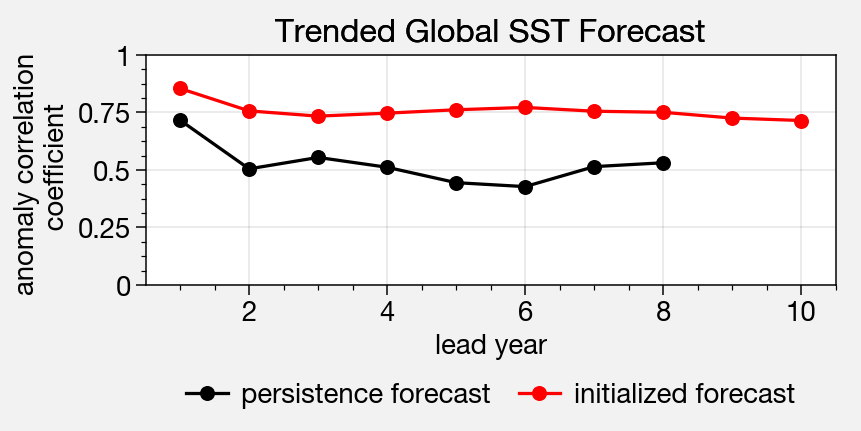

In [18]:
plot.rc.small = 11
plot.rc.large = 13
varname = 'SST'

f, ax = plot.subplots(aspect=3, axwidth='10cm',
                      bottomlegend=True)
    
p1, = ax.plot(persist['FOSI'].time, persist['FOSI'][varname],
        '-ok', markersize=6, label='persistence forecast')
p2, = ax.plot(skill['FOSI'].time, skill['FOSI'][varname],
        '-or', markersize=6, label='initialized forecast')

ax.format(ylim=[0, 1], xlim=[0.5, 10.5], xlabel='lead year',
          ylabel='anomaly correlation \n coefficient',
          title='Trended Global SST Forecast')

f.bottompanel.legend([p1, p2])

# Perfect Model Ensemble

In [19]:
# todo